In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import faiss
import pickle as pkl
from tqdm import tqdm
import argparse
import h5py
from PIL import Image

In [2]:
def calculate_compactness(embeddings, labels):
    centroids = np.array([embeddings[labels == i].mean(axis = 0) for i in np.unique(labels)])
    distances = cdist(embeddings, centroids)
    return np.mean([distances[i, labels[i]] for i in range(len(labels))])

def calculate_compactness_faiss(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == i].mean(axis = 0) for i in unique_labels])
    print('Centroids calculated')
    
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    
    # get nearest centroids for each embedding
    distances, indices = index.search(embeddings, 1)
    nearest_centroid_distances = distances.squeeze()
    print('Found nearest centroids...')
    
    compactness = np.mean([nearest_centroid_distances[i] for i in range(len(labels)) if labels[i] == indices[i, 0]])

    return compactness


def calculate_wcss_faiss(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == i].mean(axis=0) for i in unique_labels])
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    distances, _ = index.search(embeddings, 1)
    nearest_centroid_distances = distances.squeeze()
    wcss = np.sum(nearest_centroid_distances ** 2)
    return wcss



In [3]:
data_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/combined'
raw_embeds_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations'

In [4]:
ks = [4, 8, 16, 32, 64, 96, 128]

In [5]:
k = 16

In [6]:
cluster_centers = []
for item in sorted(glob.glob('/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/k_16/*/*centroids_image.npy')):
    cluster_centers.extend(np.load(item)[0])

In [7]:
np.array(cluster_centers).shape

(240, 1024)

In [8]:
centroids_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/k_32'

In [9]:
df_list = []
all_centroids = []
reassigned_clusters = []
all_dfs = sorted(glob.glob(os.path.join(data_root, f'*_across_k.csv')))
for i, item in enumerate(all_dfs):
    tissue_type = item.split('/')[-1].split('_')[0]
    csv_path = os.path.join(data_root, f'{tissue_type}_across_k.csv')
    df = pd.read_csv(csv_path, index_col = 0)
    
    reassigned_dict = {j: j+i*16 for j in range(16)}
#     print(reassigned_dict)
    df['image_prototype'] = df['k_16'].map(reassigned_dict)
#     print(df['image_prototype'].unique())
    df_list.append(df)
    reassigned_clusters.extend(list(reassigned_dict.values()))
    image_embeds_raw = np.load(os.path.join(
        centroids_root, tissue_type, f'{tissue_type}_centroids_image.npy'))

    all_centroids.extend(image_embeds_raw[0])
combined_df = pd.concat(df_list, ignore_index = True)

In [10]:
len(combined_df['image_prototype'].unique()), len(all_centroids)

(240, 480)

## K = 4

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(cluster_centers)
new_centers = kmeans.cluster_centers_
labels = kmeans.labels_

k_4_mapping = {}
for ind, label in enumerate(labels):
    k_4_mapping[ind] = label
    
combined_df['k_4_2nd_level'] = combined_df['image_prototype'].map(k_4_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,k_16,k_32,k_4,k_64,k_8,k_96,image_prototype,k_4_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,0,11,0,51,0,51,0,3
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,8,24,3,39,3,37,8,3
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,8,24,3,39,3,37,8,3
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,13,17,3,25,7,73,13,3
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,9,0,3,38,3,64,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,4,6,2,4,3,95,228,3
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,9,1,1,32,2,15,233,3
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,1,7,0,23,1,7,225,3
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,3,5,2,19,3,79,227,3


## K = 8

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_


In [14]:
k_8_mapping = {}
for ind, label in enumerate(labels):
    k_8_mapping[ind] = label

In [15]:
combined_df['k_8_2nd_level'] = combined_df['image_prototype'].map(k_8_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,k_16,k_32,k_4,k_64,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,0,11,0,51,0,51,0,3,2
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,8,24,3,39,3,37,8,3,5
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,8,24,3,39,3,37,8,3,5
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,13,17,3,25,7,73,13,3,5
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,9,0,3,38,3,64,9,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,4,6,2,4,3,95,228,3,2
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,9,1,1,32,2,15,233,3,2
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,1,7,0,23,1,7,225,3,2
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,3,5,2,19,3,79,227,3,2


## K = 16

In [ ]:

kmeans = KMeans(n_clusters=16, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_

k_16_mapping = {}
for ind, label in enumerate(labels):
    k_16_mapping[ind] = label
    
combined_df['k_16_2nd_level'] = combined_df['image_prototype'].map(k_16_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,k_16,k_32,k_4,k_64,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level,k_16_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,0,11,0,51,0,51,0,3,2,9
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,8,24,3,39,3,37,8,3,5,5
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,8,24,3,39,3,37,8,3,5,5
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,13,17,3,25,7,73,13,3,5,5
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,9,0,3,38,3,64,9,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,4,6,2,4,3,95,228,3,2,2
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,9,1,1,32,2,15,233,3,2,13
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,1,7,0,23,1,7,225,3,2,2
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,3,5,2,19,3,79,227,3,2,2


## K = 32

In [ ]:

kmeans = KMeans(n_clusters=32, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_

k_32_mapping = {}
for ind, label in enumerate(labels):
    k_32_mapping[ind] = label
    
combined_df['k_32_2nd_level'] = combined_df['image_prototype'].map(k_32_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,...,k_32,k_4,k_64,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level,k_16_2nd_level,k_32_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,...,11,0,51,0,51,0,3,2,9,9
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,...,24,3,39,3,37,8,3,5,5,3
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,...,24,3,39,3,37,8,3,5,5,3
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,...,17,3,25,7,73,13,3,5,5,3
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,...,0,3,38,3,64,9,3,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,...,6,2,4,3,95,228,3,2,2,11
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,...,1,1,32,2,15,233,3,2,13,11
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,...,7,0,23,1,7,225,3,2,2,14
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,...,5,2,19,3,79,227,3,2,2,11


In [18]:
cluster_centers = np.vstack(cluster_centers)
cluster_centers.shape

(240, 1024)

## K = 64

In [ ]:

kmeans = KMeans(n_clusters=64, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_

k_64_mapping = {}
for ind, label in enumerate(labels):
    k_64_mapping[ind] = label
    
combined_df['k_64_2nd_level'] = combined_df['image_prototype'].map(k_64_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,...,k_4,k_64,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level,k_16_2nd_level,k_32_2nd_level,k_64_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,...,0,51,0,51,0,3,2,9,9,45
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,...,3,39,3,37,8,3,5,5,3,13
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,...,3,39,3,37,8,3,5,5,3,13
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,...,3,25,7,73,13,3,5,5,3,13
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,...,3,38,3,64,9,3,5,5,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,...,2,4,3,95,228,3,2,2,11,38
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,...,1,32,2,15,233,3,2,13,11,38
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,...,0,23,1,7,225,3,2,2,14,59
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,...,2,19,3,79,227,3,2,2,11,38


## K = 96

In [ ]:

kmeans = KMeans(n_clusters=96, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_

k_96_mapping = {}
for ind, label in enumerate(labels):
    k_96_mapping[ind] = label
    
combined_df['k_96_2nd_level'] = combined_df['image_prototype'].map(k_96_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,...,k_64,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level,k_16_2nd_level,k_32_2nd_level,k_64_2nd_level,k_96_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,...,51,0,51,0,3,2,9,9,45,45
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,...,39,3,37,8,3,5,5,3,13,66
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,...,39,3,37,8,3,5,5,3,13,66
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,...,25,7,73,13,3,5,5,3,13,66
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,...,38,3,64,9,3,5,5,3,13,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,...,4,3,95,228,3,2,2,11,38,38
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,...,32,2,15,233,3,2,13,11,38,38
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,...,23,1,7,225,3,2,2,14,59,59
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,...,19,3,79,227,3,2,2,11,38,38


## K = 128

In [ ]:
kmeans = KMeans(n_clusters=128, random_state=0)

kmeans.fit(cluster_centers)

new_centers = kmeans.cluster_centers_

labels = kmeans.labels_

k_128_mapping = {}
for ind, label in enumerate(labels):
    k_128_mapping[ind] = label
    
combined_df['k_128_2nd_level'] = combined_df['image_prototype'].map(k_128_mapping)
combined_df

,level_0,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj,k_128,...,k_8,k_96,image_prototype,k_4_2nd_level,k_8_2nd_level,k_16_2nd_level,k_32_2nd_level,k_64_2nd_level,k_96_2nd_level,k_128_2nd_level
0,1085058,NCBI603,0,11076,10004,11188.932330,10116.230130,11074,10002,44,...,0,51,0,3,2,9,9,45,45,127
1,1085059,NCBI603,1,8048,6207,8160.518927,6319.420076,8046,6205,51,...,3,37,8,3,5,5,3,13,66,66
2,1085060,NCBI603,2,9829,7439,9941.938576,7551.755996,9827,7437,51,...,3,37,8,3,5,5,3,13,66,66
3,1085061,NCBI603,3,12858,8776,12970.351978,8888.075946,12856,8774,124,...,7,73,13,3,5,5,3,13,66,66
4,1085062,NCBI603,4,11611,8672,11723.358224,8784.091917,11609,8670,116,...,3,64,9,3,5,5,3,13,66,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534082,830394,NCBI690,1955,5662,5098,5774.000000,5210.000000,5663,5099,107,...,3,95,228,3,2,2,11,38,38,38
534083,830395,NCBI690,1956,7848,5440,7960.000000,5552.000000,7849,5441,118,...,2,15,233,3,2,13,11,38,38,38
534084,830396,NCBI690,1957,1786,4932,1898.000000,5044.000000,1787,4933,7,...,1,7,225,3,2,2,14,59,59,121
534085,830397,NCBI690,1958,9142,6648,9254.000000,6760.000000,9143,6649,79,...,3,79,227,3,2,2,11,38,38,38


In [ ]:
all_embed_files = sorted(glob.glob(os.path.join('/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations', '*image_embeds_raw.npy')))
ex = np.load(all_embed_files[0])
ex.shape

(3069, 1024)

In [24]:
total_rows = 0
embed_dim = 1024
rows_per_file = []
for f in tqdm(all_embed_files):
    arr = np.load(f)
    rows_per_file.append(arr.shape[0])
    total_rows += arr.shape[0]

big_matrix = np.empty((total_rows, embed_dim), dtype = np.float32)
start_row = 0
for (f, n_rows) in tqdm(zip(all_embed_files, rows_per_file)):
    arr = np.load(f)
    big_matrix[start_row:start_row+n_rows:, ] = arr
    start_row += n_rows

big_matrix.shape
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.87s/it]
15it [1:01:42, 246.86s/it]


(534087, 1024)

In [32]:
np.save(os.path.join('/raid/mpleasure/data_deepstorage/st_projects/visualizations/big_matrix_16.npy'), big_matrix)

In [24]:
all_embeds = []
all_embed_files = sorted(glob.glob(os.path.join('/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations', '*image_embeds_raw.npy')))
len(all_embed_files) 

for file in tqdm(all_embed_files):
    embed = np.load(file)
    all_embeds.append(embed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:40<00:00, 38.72s/it]


In [25]:
ks = [4, 8, 16, 32, 64, 96, 128]

In [26]:
labels

array([127,  28, 114,  48,  28, 114,  45, 127,  66,  66,   2,  48,  45,
        66,  56,   3, 117,  43,  98,  69,  58,  39,  12,  58, 111,  50,
        85,  26,  76,  90,  16, 123,  81,   4,  25, 103,  52,  94,   5,
        42,  42,   5,  96, 105,  81, 100,  29,  29,  86,  18,  18,  86,
       116, 124,  39,  68,  68,  76,  33,  18,  22,  70,  76,  22, 118,
       118,  57,  44, 118,  14,  57,  54,  11,  44,  54,  55, 118, 118,
        26,  11,  89,  89,   7,   7,   7,  89,  87,   7,  89,  89,  67,
        67,  67,   7,   7,   7,  53,  55,  55,  34,  83,  60,  53,  53,
        83,  53,  34,   6,  83,  53,   6,  60,  35,  40, 120,  21,  10,
        80,  21,  92, 110,  21, 102,  41,   2,  10,  49,  49,   2, 109,
         2,   0,  15, 122,  71,  15,  93,  34,  26,  99,  95, 113,  37,
        61,  20,  71,  91,   2,  31,   1,  91, 119,   1,   1,  31,  20,
        65, 101, 112,  36,  63,  23,  63,  63,  23,  97,  73,   8,   8,
         8,  73,  85, 108,  32,  23, 108,  27,  84,  62,  84,  8

In [27]:
len(labels)

240

In [ ]:
embeds = np.vstack(all_embeds)

In [ ]:
embeds.shape

In [ ]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = combined_df[f'k_{k}_2nd_level'].values
    wcss = calculate_wcss_faiss(big_matrix, labels)
    wcss_vals.append(wcss)

KeyboardInterrupt: 

In [ ]:
plt.plot(ks, wcss_vals, 'bx-')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('across all tissues - k_8')
plt.plot()

In [ ]:
plt.plot(ks, wcss_vals, 'bx-')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('Clustering Across All Tissue Types')
plt.plot()

In [ ]:
plt.plot(ks, wcss_vals, 'bx-')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('across all tissues - k_32')
plt.plot()

In [3]:
## PLOTS

In [7]:
from sklearn.preprocessing import StandardScaler

In [17]:
wcss_vals = np.load('/raid/mpleasure/data_deepstorage/st_projects/visualizations/wcss_vals_16_2nd_step.npy')
wcss_vals.shape

(7,)

In [18]:
wcss_vals = np.expand_dims(wcss_vals, axis=1)

In [19]:
scaler = StandardScaler()
scaled_wcss = scaler.fit_transform(wcss_vals)

In [20]:
scaled_wcss.shape

(7, 1)

In [13]:
ks = [4, 8, 16, 32, 64, 96, 128]


In [22]:
colors = [
  "#000000", # Black
  "#E69F00", # Orange
  "#56B4E9", # Sky Blue
  "#009E73", # Bluish Green
  "#F0E442", # Yellow
  "#0072B2", # Blue
  "#D55E00", # Vermillion
  "#CC79A7"  # Reddish Purple
]
line_styles = ["-", ":"]

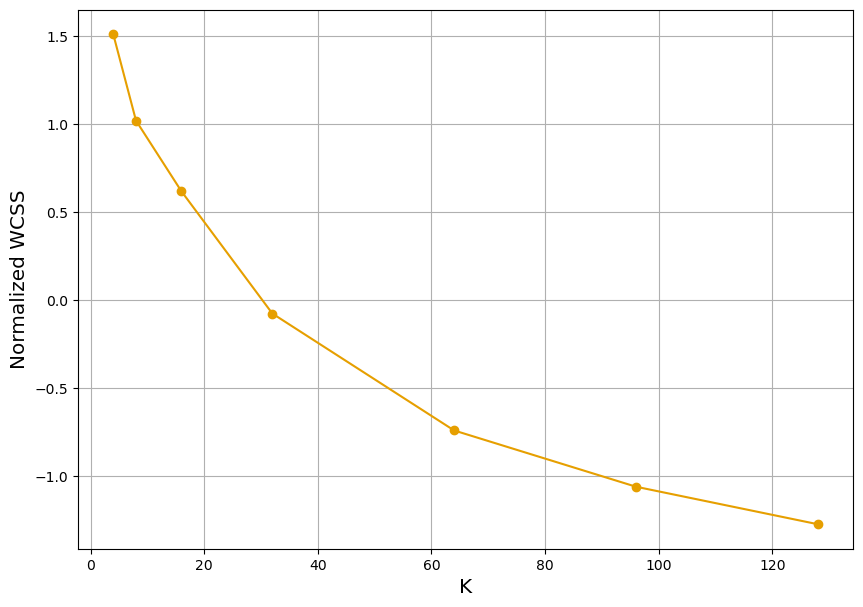

In [28]:
plt.figure(figsize = (10, 7))
plt.plot(ks, scaled_wcss.squeeze(), marker = 'o', linestyle = line_styles[0], color=colors[1])
plt.xlabel('K', fontsize = 'x-large')
plt.ylabel('Normalized WCSS', fontsize = 'x-large')
plt.grid(True)
plt.plot()
plt.savefig(os.path.join('/raid/mpleasure/data_deepstorage/st_projects/visualizations', 'clustering_higher_level.png'))